In [159]:
from packages.display.core import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [148]:
%qtconsole

# Testing Band 9

## Creation of Data Cubes

Creation of the Synthetic Data Cubes ALMA-like using ASYDO Project.
Parameters:

 - isolist    : subset of the list of isotopes to generate a cube

 cube_params:

 - freq    : spectral center (frequency)
 - alpha   : right-ascension center (degrees
 - delta   : declination center (degrees
 - spe_res : spectral resolution (MHz)
 - spe_bw  : spectral bandwidth (MHz)
 - s_f, s_a : skew-normal distrib, s_f: full width at half maximum, alpha: curtosis parameter. 

In [177]:
cube_params = {
  'freq'     : 604000,
  'alpha'    : 0,
  'delta'    : 0,
  'spe_bw'   : 4000,
  'spe_res'  : 1,
  's_f'      : 8,
  's_a'      : 0}

To select the isolist, the wavelength range of the cube is obtained, and a searching from theoretical catalog Splatalogue is performed. All the isotopes that have spectral lines on the range of the cube are determinated.

In [4]:
freq_init = cube_params['freq'] - cube_params['spe_bw']/2.0
freq_end = cube_params['freq'] + cube_params['spe_bw']/2.0

molist_present = theoretical_presence(molist, freq_init, freq_end)

Then, we get all the possible combination sets of the previously determined isotopes.

In [10]:
all_subsets = sum(map(lambda r: list(combinations(molist_present, r)),
                                range(1, len(molist_present)+1)), [])

Finally, random sets previously determinated are selected in order to generate the data cubes.

In [11]:
random_index = np.random.randint(len(all_subsets), size=25)

isolist = []
for i in random_index:
    isolist.append(all_subsets[i])
    
save_isolist(isolist)

In [5]:
isolist = load_isolist()

### Generate Datacubes in Band 9, Fixed Width

In [4]:
log=open('data/isolist_fixed_width.log', 'w')
cube_n = 0
cube_name = 'data/cube_fixed_width_'
for i in range(0, 25):

    # Creation of the cube
    gen_cube(isolist[i], cube_params, cube_name + str(cube_n))

    log.write(cube_name + ': ' + str(isolist[i]) + '\n')
    cube_n += 1
log.close()

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [packages.asydopy.vu]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


### Generate Datacubes in Band 9, Variable (TO DO: Fix variable width in ASYDO) Width

In [9]:
log=open('data/isolist_variable_width.log', 'w')
cube_n = 25
cube_name = 'data/cube_variable_width_'
for i in range(0, 25):

    # Creation of the cube
    gen_cube_variable_width(isolist[i], cube_params, cube_name + str(cube_n))
    
    log.write(cube_name + ': ' + str(isolist[i]) + '\n')
    cube_n += 1
log.close()

## Creation of Dictionary

We create the words necessary to fit a sparse coding model to the observed spectra in the previous created cube.
It returns a DataFrame with a vector for each theoretical line for each isotope in molist

In [ ]:
dictionary = gen_words(molist, cube_params)
save_dictionary(dictionary, 'band_9')

In [3]:
dictionary = gen_words(molist, cube_params, True)
save_dictionary(dictionary, 'band_9_dual')

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


In [4]:
dictionary = load_dictionary('band_9')

In [7]:
dictionary = load_dictionary('band_9_dual')

## Recalibration of Dictionary

In [111]:
confusion_matrix = []
results = []

In [112]:
for i in range(0, 50):
    if (i == 0):
        cube_name = 'data/cube_fixed_width_'
    if (i == 25):
        cube_name = 'data/cube_variable_width_'
        
    file_path = cube_name + str(i) + '.fits'
    
    train_pixel = (1, 1)
    dictionary_recal, detected_peaks = recal_words(file_path, dictionary, cube_params)
    
    X = get_values_filtered_normalized(file_path, train_pixel, cube_params)

    y_train = get_fortran_array(np.asmatrix(X))
    dictionary_recal_fa = np.asfortranarray(dictionary_recal,
                                            dtype= np.double)
    
    lambda_param = 0
    for idx in range(0, len(detected_peaks)):
        if detected_peaks[idx] != 0:
            lambda_param += 1
    
    param = {
      'lambda1' : lambda_param,
      # 'L': 1,
      'pos' : True,
      'mode' : 0,
      'ols' : True,
      'numThreads' : -1}
    
    alpha = spams.lasso(y_train, dictionary_recal_fa, **param).toarray()
    total = np.inner(dictionary_recal_fa, alpha.T)
    
    if i == 0:
        confusion_matrix = [get_confusion_matrix(dictionary_recal, alpha,
                                   file_path, cube_params, True)]
        results = [get_results(confusion_matrix[i])]
    else:
        confusion_matrix.append(get_confusion_matrix(dictionary_recal, alpha,
                                               file_path, cube_params, True))
        results.append(get_results(confusion_matrix[i]))

In [14]:
confusion_matrix[0]

,SO2v2=1-f605781.546,SO2v2=1-f603981.474,H213CO-f602083.584,SO2v2=1-f604315.0048,SO2v2=1-f605984.3296,SO2v2=1-f602454.6493,SO2v2=1-f604398.1207,H2C34S-f605585.4505,H2C34S-f604710.9998,H13CNv=0-f604267.914,H2C34S-f605200.1552,H2C18O-f603231.51,SO2v2=1-f603332.8487,SO2v2=1-f604022.2577,H2C34S-f605935.8198,SO2v2=1-f605850.4063,H213CS-f602149.9892,SO2v2=1-f604728.5953
CH3OHvt=0-f602233.197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34SO2v=0-f604376.563,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H213CO-f602083.584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
results[0]

,Precision,Recall,F-Score
SO2v2=1-f605781.546,0,0,0
SO2v2=1-f603981.474,0,0,0
H213CO-f602083.584,0,0,0
SO2v2=1-f604315.0048,0,0,0
SO2v2=1-f605984.3296,0,0,0
SO2v2=1-f602454.6493,0,0,0
SO2v2=1-f604398.1207,0,0,0
H2C34S-f605585.4505,0,0,0
H2C34S-f604710.9998,0,0,0
H13CNv=0-f604267.914,0,0,0


# Testing Band 7

### Generate Datacubes in Band 7, Fixed Width

In [125]:
cube_params['freq'] = 277000

In [13]:
log=open('data/isolist_fixed_width.log', 'w')
cube_n = 50
cube_name = 'data/cube_fixed_width_'
for i in range(0, 25):

    # Creation of the cube
    gen_cube(isolist[i], cube_params, cube_name + str(cube_n))

    log.write(cube_name + ': ' + str(isolist[i]) + '\n')
    cube_n += 1
log.close()

### Generate Datacubes in Band 7, Variable (TO DO: Fix variable width in ASYDO) Width

In [16]:
log=open('data/isolist_fixed_width.log', 'w')
cube_n = 75
cube_name = 'data/cube_variable_width_'
for i in range(0, 25):

    # Creation of the cube
    gen_cube_variable_width(isolist[i], cube_params, cube_name + str(cube_n))

    log.write(cube_name + ': ' + str(isolist[i]) + '\n')
    cube_n += 1
log.close()

## Creation of Dictionary

In [14]:
dictionary = gen_words(molist, cube_params)
save_dictionary(dictionary, 'band_7')

In [126]:
dictionary = gen_words(molist, cube_params, True)
save_dictionary(dictionary, 'band_7_dual')

In [ ]:
dictionary = load_dictionary('band_7')

In [119]:
dictionary = load_dictionary('band_7_dual')

### Training

### Recalibration of the Dictionary

In [132]:
for i in range(50, 100):
    if (i == 50):
        cube_name = 'data/cube_fixed_width_'
    if (i == 75):
        cube_name = 'data/cube_variable_width_'
        
    file_path = cube_name + str(i) + '.fits'
    
    train_pixel = (1, 1)
    dictionary_recal, detected_peaks = recal_words(file_path, dictionary, cube_params)
    
    X = get_values_filtered_normalized(file_path, train_pixel, cube_params)

    y_train = get_fortran_array(np.asmatrix(X))
    dictionary_recal_fa = np.asfortranarray(dictionary_recal,
                                            dtype= np.double)
    
    lambda_param = 0
    for idx in range(0, len(detected_peaks)):
        if detected_peaks[idx] != 0:
            lambda_param += 1
    
    param = {
      'lambda1' : lambda_param,
      # 'L': 1,
      'pos' : True,
      'mode' : 0,
      'ols' : True,
      'numThreads' : -1}
    
    alpha = spams.lasso(y_train, dictionary_recal_fa, **param).toarray()
    total = np.inner(dictionary_recal_fa, alpha.T)
    
  
    confusion_matrix.append(get_confusion_matrix(dictionary_recal, alpha,
                                           file_path, cube_params, True))
    results.append(get_results(confusion_matrix[i]))

### Testing

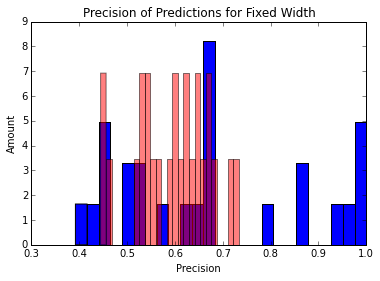

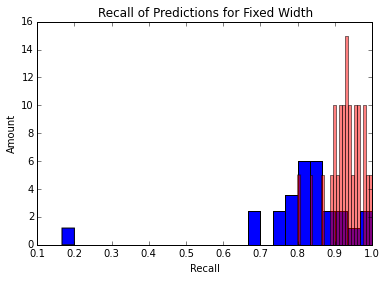

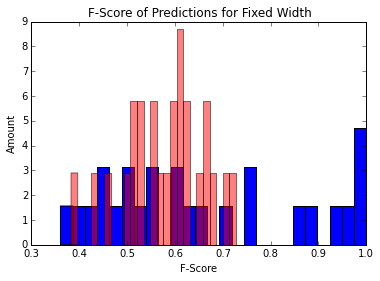

In [166]:
plt.title("Precision of Predictions for Fixed Width")
plt.xlabel("Precision")
plt.ylabel("Amount")
plt.legend()
plt.hist([np.mean(means["Precision"]) for means in results[:25]], 25, normed=True, color='b', alpha=1, label='Band 9')
plt.hist([np.mean(means["Precision"]) for means in results[50:75]], 25, normed=True, color='r', alpha=0.5, label='Band 7')
plt.show()

plt.title("Recall of Predictions for Fixed Width")
plt.xlabel("Recall")
plt.ylabel("Amount")
plt.legend()
plt.hist([np.mean(means["Recall"]) for means in results[:25]], 25, normed=True, color='b', alpha=1, label='Band 9')
plt.hist([np.mean(means["Recall"]) for means in results[50:75]], 25, normed=True, color='r', alpha=0.5, label='Band 7')
plt.show()

plt.title("F-Score of Predictions for Fixed Width")
plt.xlabel("F-Score")
plt.ylabel("Amount")
plt.legend()
plt.hist([np.mean(means["F-Score"]) for means in results[:25]], 25, normed=True, color='b', alpha=1, label='Band 9')
plt.hist([np.mean(means["F-Score"]) for means in results[50:75]], 25, normed=True, color='r', alpha=0.5, label='Band 7')
plt.show()

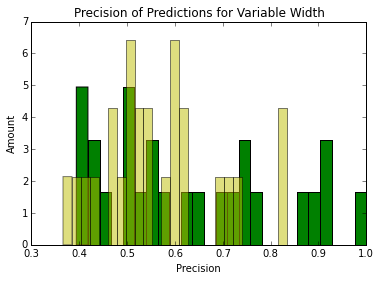

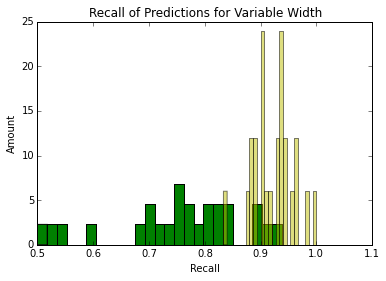

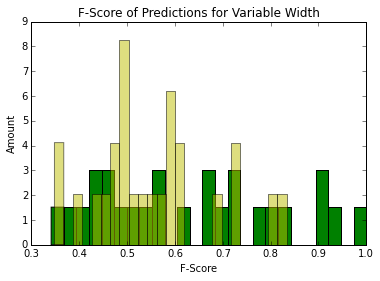

In [168]:
plt.title("Precision of Predictions for Variable Width")
plt.xlabel("Precision")
plt.ylabel("Amount")
plt.legend()
plt.hist([np.mean(means["Precision"]) for means in results[25:50]], 25, normed=True, color='g', alpha=1, label='Band 9')
plt.hist([np.mean(means["Precision"]) for means in results[75:]], 25, normed=True, color='y', alpha=0.5, label='Band 7')
plt.show()

plt.title("Recall of Predictions for Variable Width")
plt.xlabel("Recall")
plt.ylabel("Amount")
plt.legend()
plt.hist([np.mean(means["Recall"]) for means in results[25:50]], 25, normed=True, color='g', alpha=1, label='Band 9')
plt.hist([np.mean(means["Recall"]) for means in results[75:]], 25, normed=True, color='y', alpha=0.5, label='Band 7')
plt.show()

plt.title("F-Score of Predictions for Variable Width")
plt.xlabel("F-Score")
plt.ylabel("Amount")
plt.legend()
plt.hist([np.mean(means["F-Score"]) for means in results[25:50]], 25, normed=True, color='g', alpha=1, label='Band 9')
plt.hist([np.mean(means["F-Score"]) for means in results[75:]], 25, normed=True, color='y', alpha=0.5, label='Band 7')
plt.show()

Blending case

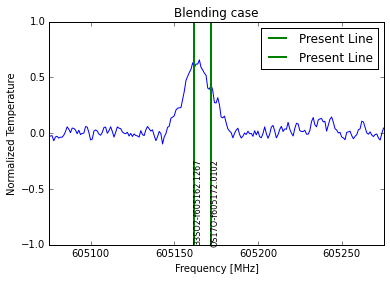

In [202]:
file_path = "data/cube_fixed_width_6.fits"
train_pixel = (1, 1)
x = get_freq_index_from_params(cube_params)
y = get_values_filtered_normalized(file_path, train_pixel, cube_params)
plt.plot(x, y)
plt.legend(loc='upper right')
plt.xlim(xmin = 605075, xmax = 605275)
plt.ylim(ymin = -1,ymax = 1)

lines = get_lines_from_fits(file_path)
current_isotopes = [""]
for line in lines:
    isotope_frequency = int(line[1])
    isotope_name = line[0] + "-f" + str(line[1])
    if isotope_frequency in range(605075, 605275) \
    and line[0] not in current_isotopes:
        # Shows lines really present
        plt.axvline(x=isotope_frequency, ymin=0, ymax= 3, color='g', linewidth=2, label='Present Line')
        plt.text(isotope_frequency, -0.3, isotope_name, size='8', rotation='vertical')
        current_isotopes.append(line[0])

plt.title("Blending case")
plt.xlabel("Frequency [MHz]")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.ylabel("Normalized Temperature")
plt.legend()
plt.show()

Hyperfine lines case

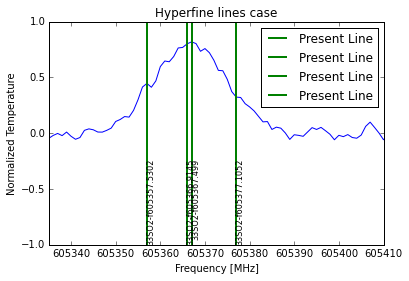

In [204]:
file_path = "data/cube_fixed_width_6.fits"
train_pixel = (1, 1)
x = get_freq_index_from_params(cube_params)
y = get_values_filtered_normalized(file_path, train_pixel, cube_params)
plt.plot(x, y)
plt.legend(loc='upper right')
plt.xlim(xmin = 605335, xmax = 605410)
plt.ylim(ymin = -1,ymax = 1)

lines = get_lines_from_fits(file_path)
for line in lines:
    isotope_frequency = int(line[1])
    isotope_name = line[0] + "-f" + str(line[1])
    if isotope_frequency in range(605335, 605410):
        # Shows lines really present
        plt.axvline(x=isotope_frequency, ymin=0, ymax= 3, color='g', linewidth=2, label='Present Line')
        plt.text(isotope_frequency, -0.3, isotope_name, size='8', rotation='vertical')

plt.title("Hyperfine lines case")
plt.xlabel("Frequency [MHz]")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.ylabel("Normalized Temperature")
plt.legend()
plt.show()

Double peaks for single Line

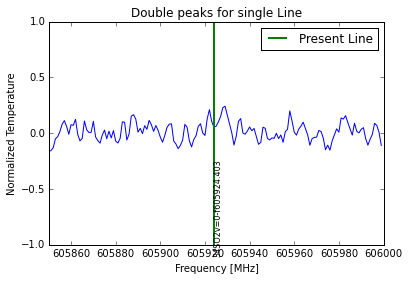

In [208]:
file_path = "data/cube_fixed_width_13.fits"
train_pixel = (1, 1)
x = get_freq_index_from_params(cube_params)
y = get_values_filtered_normalized(file_path, train_pixel, cube_params)
plt.plot(x, y)
plt.legend(loc='upper right')
plt.xlim(xmin = 605850, xmax = 606000)
plt.ylim(ymin = -1,ymax = 1)

lines = get_lines_from_fits(file_path)
for line in lines:
    isotope_frequency = int(line[1])
    isotope_name = line[0] + "-f" + str(line[1])
    if isotope_frequency in range(605850, 606000):
        # Shows lines really present
        plt.axvline(x=isotope_frequency, ymin=0, ymax= 3, color='g', linewidth=2, label='Present Line')
        plt.text(isotope_frequency, -0.3, isotope_name, size='8', rotation='vertical')

plt.title("Double peaks for single Line")
plt.xlabel("Frequency [MHz]")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.ylabel("Normalized Temperature")
plt.legend()
plt.show()